In [1]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, AutoModel, AutoFeatureExtractor
from transformers import AutoFeatureExtractor, ASTFeatureExtractor, ASTForAudioClassification, ASTModel
from IPython.display import Audio, display
import librosa
import soundfile as sf
import os
import faiss

In [3]:
# Load the Wav2Vec2.0 tokenizer and model
model = AutoModel.from_pretrained('facebook/wav2vec2-base-960h')
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

feature_extractor_ast = AutoFeatureExtractor.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')
model_ast = ASTModel.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 were not used when initializing ASTModel: ['classifier.dense.bias', 'classifier.layernorm.bias', 'classifier.layernorm.weight', 'classifier.dense.weight']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing

In [4]:
model.to('cuda:0')
model_ast.to('cuda:0')

ASTModel(
  (embeddings): ASTEmbeddings(
    (patch_embeddings): ASTPatchEmbeddings(
      (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ASTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ASTLayer(
        (attention): ASTAttention(
          (attention): ASTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ASTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ASTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

## Resampling the songs to 16000 sample rate and splitting the track into 10 second small tracks

In [2]:
sample_rate = 16000
number_of_seconds = 10
dir_name = 'wav_files'
dest_dir = 'wav_files/10_seconds_samples/'

In [ ]:

for files in os.listdir(dir_name):
    if '.wav' in files:
        file_path = os.path.join(dir_name,files)
        x, sr = librosa.load(file_path, sr=16000)
        print("Splitting file {} with sample rate {}".format(files, sr))
        initial_seconds = number_of_seconds
        for i in range(0, len(x), number_of_seconds * sr):
            y = x[i: number_of_seconds * sr + (i)]
            out_file = str(initial_seconds) + "_" + files
            initial_seconds = initial_seconds + number_of_seconds
            sf.write(os.path.join(dest_dir,out_file), y, sr)
            


In [ ]:
x, sr = librosa.load('wav_files/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav', sr=16000)

In [ ]:
sr

In [ ]:
waveform, sample_rate = torchaudio.load('wav_files/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav')
waveform = waveform.squeeze().numpy()

print(sample_rate)

In [ ]:
display(Audio(waveform, rate=sample_rate))
print()

## Embeddings generator

In [ ]:
input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=sample_rate).to('cuda:0')

In [ ]:
with torch.no_grad():
    embeddings = model_ast(**input_values).last_hidden_state
    embeddings = embeddings.mean(dim=1)
    print(embeddings.shape)

In [ ]:
embeddings.shape[1]

In [ ]:
embeddings.to('cpu').detach().numpy()

## Generate embeddings for all the small portions of the track and store it in FAISS - Wav2Vec2 and AST

In [35]:
index_wav_vec = faiss.IndexFlatL2(embeddings.shape[1])
index_ast = faiss.IndexFlatL2(embeddings.shape[1])

In [36]:
index_wav_vec.ntotal

0

In [37]:
index_ast.ntotal

0

In [44]:
index_id = 0
faiss_index_lookup_samples = {}
embeddings_ast = []
embeddings_wav = []

In [45]:
for files in os.listdir(dest_dir):
    try:
        waveform, sample_rate = torchaudio.load(os.path.join(dest_dir,files))
        print("Processing files {} with sample rate {}".format(files, sample_rate))
        waveform = waveform.squeeze().numpy()
        
        #wav2vec2
        input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
        embeddings = model(**input_values).last_hidden_state
        embeddings = embeddings.mean(dim=1).to('cpu').detach().numpy()
        embeddings_wav.append(embeddings[0])
        index_wav_vec.add(embeddings)
        
        #ast
        input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
        embeddings = model_ast(**input_values).last_hidden_state
        embeddings = embeddings.mean(dim=1).to('cpu').detach().numpy()
        embeddings_ast.append(embeddings[0])
        index_ast.add(embeddings)
        
        # creating index lookup
        faiss_index_lookup_samples[index_id] = os.path.join(dest_dir,files)
        index_id = index_id + 1
    except Exception as e:
        print("Error files {}".format(files))
        print(e)

Processing files 260_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 390_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 20_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 390_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 30_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 240_Night Glitches.mp3.wav with sample rate 16000
Processing files 420_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 70_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 3120_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 500_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 180_A1. Jon Hester - Inertia.mp3.wav wit

Processing files 80_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000
Processing files 20_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 1660_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 560_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 240_Jon Hester - Flex.mp3.wav with sample rate 16000
Processing files 370_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 3020_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 290_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 380_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 170_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 10_different.mp3.wav with sample rate 16000
Processing files 410_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 410_Oxia & Nicolas Masseyeff - You Know (Original

Processing files 90_Delilah (pull me out of this).mp3.wav with sample rate 16000
Processing files 90_Rocket (Radio-Edit).mp3.wav with sample rate 16000
Processing files 190_Serge Devant - Life Trap.mp3.wav with sample rate 16000
Processing files 210_Jon Hester - Part 4.mp3.wav with sample rate 16000
Processing files 2150_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 110_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 290_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 30_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 310_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 460_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 410_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 310_Be

Processing files 10_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 440_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 180_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000
Processing files 310_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000
Processing files 360_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 200_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 130_Second Change - Diversions Music 09.mp3.wav with sample rate 16000
Processing files 620_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 290_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 480_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 60_Gemini.mp3.wav with sample rate 16000
Processing files 280_Sanchä - Carpe (Original M

Processing files 350_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 260_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 290_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 330_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000
Processing files 210_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000
Processing files 30_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 210_Audiojack - Higher.mp3.wav with sample rate 16000
Processing files 280_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 10_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 70_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000
Processing files 150_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample 

Processing files 10_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000
Processing files 80_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000
Processing files 200_Jon Hester - Part 4.mp3.wav with sample rate 16000
Processing files 370_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 200_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000
Processing files 560_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 240_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000
Processing files 230_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 40_different.mp3.wav with sample rate 16000
Processing files 620_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 290_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.

Processing files 280_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 530_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 150_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 70_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000
Processing files 540_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 70_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 100_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 140_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 500_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 160_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000
Processing files 310_Mariano Mellino & 

Processing files 390_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 30_Jon Hester - Wonder.mp3.wav with sample rate 16000
Processing files 30_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000
Processing files 340_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 380_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 370_Trigger.mp3.wav with sample rate 16000
Processing files 460_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 150_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 400_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 240_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 60_Samuel L Session - Can You Relate (Joris

Processing files 420_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 10_A1 Jon Hester Flow.mp3.wav with sample rate 16000
Processing files 100_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000
Processing files 2840_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 230_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 220_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 80_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 210_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000
Processing files 250_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 50_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000
Processing files 920_KW20 - Various Artists.mp3.wav with sample rate 16000
Proc

Processing files 250_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000
Processing files 240_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 310_Pulchra.mp3.wav with sample rate 16000
Processing files 250_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 320_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 200_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 70_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 150_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 310_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 10_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 

Processing files 70_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 210_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 310_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 220_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 150_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 110_Odonien.mp3.wav with sample rate 16000
Processing files 290_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000
Processing files 20_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 140_Jon Hester - Lights Down.mp3.wav with sample rate 16000
Processing files 90_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 10_Ben Böhmer - Promise You.mp3.wav with sample rate 16000
Processing files 400_Dosem - 

Processing files 180_different.mp3.wav with sample rate 16000
Processing files 160_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000
Processing files 3060_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 280_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 420_Magnetism.mp3.wav with sample rate 16000
Processing files 420_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 110_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000
Processing files 430_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 10_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 170_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 310_Jon Hester - Sirens.mp3.wav with sample rate 16000
Processing files 320_Mat.Joe – Nighthawk (Dos

Processing files 110_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 10_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000
Processing files 110_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 120_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000
Processing files 140_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 400_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 110_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 310_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000
Processing files 20_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000
Processing files 240_together.mp3.wav with sample rate 16000
Processing files 80_AiKAi - Main Sequence (Original 

Processing files 270_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 2690_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 390_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 410_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 360_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 240_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 430_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 30_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 130_Das Talent.mp3.wav with sample rate 16000
Processing files 350_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 90_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files

Processing files 570_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 260_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 380_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 180_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 200_Jon Hester - Lights Down.mp3.wav with sample rate 16000
Processing files 330_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 210_Das Talent.mp3.wav with sample rate 16000
Processing files 300_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 60_Jon Hester - Equinox.mp3.wav with sample rate 16000
Processing files 290_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 440_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 420_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp

Processing files 480_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 150_Jon Hester - Sirens.mp3.wav with sample rate 16000
Processing files 100_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 350_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000
Processing files 590_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 140_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 310_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000
Processing files 60_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 50_Time Is an Illusion.mp3.wav with sample rate 16000
Processing files 130_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 180_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000
Processing files 360_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner 

Processing files 20_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000
Processing files 280_Venen.mp3.wav with sample rate 16000
Processing files 160_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 160_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000
Processing files 340_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 200_Dust.mp3.wav with sample rate 16000
Processing files 1840_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 80_Gemini.mp3.wav with sample rate 16000
Processing files 410_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 420_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 130_Venen.mp3.wav with sample rate 16000
Processing files 190_Jon Hester - Tension Wire.mp3.wav with sample rate 16000
Processing files

Processing files 290_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 120_Second Change - Diversions Music 09.mp3.wav with sample rate 16000
Processing files 190_Gdansk.mp3.wav with sample rate 16000
Processing files 160_Ray of Hope (Original Mix).mp3.wav with sample rate 16000
Processing files 580_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 60_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 200_Kaskade - Never Sleep Alone.mp3.wav with sample rate 16000
Processing files 180_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000
Processing files 160_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 3080_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 280_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000
Processing files 250_Ben Böhmer - Promise

Processing files 90_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 180_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 30_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 50_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 320_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 370_François Ier - Neptune.mp3.wav with sample rate 16000
Processing files 230_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000
Processing files 200_Magnetism.mp3.wav with sample rate 16000
Processing files 150_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 200_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 220_Jon Hester - Beatwave.mp3.wav with s

Processing files 160_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 170_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000
Processing files 50_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000
Processing files 390_Pulchra.mp3.wav with sample rate 16000
Processing files 480_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 200_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000
Processing files 360_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 300_Caribou - Mars.mp3.wav with sample rate 16000
Processing files 440_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 110_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 130_Ben Böhmer - Promise You.mp3.wav with sample rate 16000
Processing files 180_Jon Hest

Processing files 70_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 440_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 120_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 330_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 390_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 370_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 50_D Mayer - Aleifr (Original Mix) SNIPPET.mp3.wav with sample rate 16000
Processing files 2260_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 190_Dvlex - On The D Floor.mp3.wav with sample rate 16000
Processing files 90_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 290_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 110

Processing files 240_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 710_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 100_Grey Waves.mp3.wav with sample rate 16000
Processing files 310_Grey Waves.mp3.wav with sample rate 16000
Processing files 450_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 210_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 370_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000
Processing files 50_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 400_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 400_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 380_Mazlum Kivanc -

Processing files 1900_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 240_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 350_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 220_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 150_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 60_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 190_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 460_Parple - Believe.mp3.wav with sample rate 16000
Processing files 350_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 160_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 140_My Path.mp3.wav with sampl

Processing files 240_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 400_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 40_Open Your Eyes.mp3.wav with sample rate 16000
Processing files 180_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000
Processing files 180_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 170_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 10_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000
Processing files 30_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 80_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000
Processing files 60_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample ra

Processing files 110_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 290_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000
Processing files 300_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000
Processing files 220_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 100_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 320_Flashlight.mp3.wav with sample rate 16000
Processing files 210_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 370_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 360_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 240_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000
Processing files 320_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Accele

Processing files 270_Parple - Believe.mp3.wav with sample rate 16000
Processing files 280_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 40_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 280_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 100_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 100_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000
Processing files 240_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 90_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000
Processing files 190_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000
Processing files 70_Alex Dimou fea

Processing files 110_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 200_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000
Processing files 30_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 210_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 300_Open Your Eyes.mp3.wav with sample rate 16000
Processing files 70_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 380_Jon Hester - Wonder.mp3.wav with sample rate 16000
Processing files 190_Jon Hester - Expanse.mp3.wav with sample rate 16000
Processing files 560_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 120_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 130_Phaeton.mp3.wav with sample rate 16000
Processing files 110_Open Your Eyes.mp3.wav with sample rate 16000
Processin

Processing files 360_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 90_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 60_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 40_Rob Kali - See Me.mp3.wav with sample rate 16000
Processing files 440_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 20_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 330_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 530_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 580_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 230_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000
Processing files 400_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 80_Weird (Unweird

Processing files 10_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 70_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 250_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 120_Time Is an Illusion.mp3.wav with sample rate 16000
Processing files 370_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 330_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000
Error files 100_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav
Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size
Processing files 220_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 40_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000
Processing files 230_Ben Böhmer 

Processing files 320_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000
Processing files 150_Parple - Believe.mp3.wav with sample rate 16000
Processing files 30_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 150_Universe.mp3.wav with sample rate 16000
Processing files 250_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 160_Acid Rain.mp3.wav with sample rate 16000
Processing files 30_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 280_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 60_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 50_Magnetism.mp3.wav with sample rate 16000
Processing files 140_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Proces

Processing files 500_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 170_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 260_Invinsible.mp3.wav with sample rate 16000
Processing files 340_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 110_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 60_Modular.mp3.wav with sample rate 16000
Processing files 280_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 390_Night Glitches.mp3.wav with sample rate 16000
Processing files 80_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 20_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000
Processing files 70_Dvlex - On The D Floor.mp3.wav with sample rate 16000
Processing files 120_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000
Pr

Processing files 90_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000
Processing files 1730_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 170_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 380_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 460_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 290_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000
Processing files 210_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 100_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 240_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000
Processing files 290_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000


Processing files 3240_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 50_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 1560_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 270_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 290_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 330_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 30_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 80_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 40_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 360_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000
Processing files 140_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 270_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 280_Jon 

Processing files 180_Jon Hester - Shadows.mp3.wav with sample rate 16000
Processing files 380_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 240_Time Is an Illusion.mp3.wav with sample rate 16000
Processing files 270_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 30_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 430_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 230_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 80_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 50_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 240_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 80_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 90_Dust.mp3.wav with sample rate 

Processing files 250_Jon Hester - Arise.mp3.wav with sample rate 16000
Processing files 20_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000
Processing files 100_Rob Kali - See Me.mp3.wav with sample rate 16000
Processing files 100_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 250_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 290_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 40_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 310_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 260_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000
Processing files 250_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 300_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 100_Free (Short Edit).mp3.wav with 

Processing files 40_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000
Processing files 210_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 180_Free (Short Edit).mp3.wav with sample rate 16000
Processing files 250_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 20_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 190_Second Change - Diversions Music 09.mp3.wav with sample rate 16000
Processing files 110_Flashlight.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Lights Down.mp3.wav with sample rate 16000
Processing files 170_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 170_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 230_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 50_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 340_Benno Blome - Whi

Processing files 120_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 10_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000
Processing files 80_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000
Processing files 230_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 200_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 50_Dreamless.mp3.wav with sample rate 16000
Processing files 110_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 440_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 70_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 80_Ben Böhmer - Vale.mp3.wav with sample rate 16000
Processing files 370_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 260_Denis The Nig

Processing files 290_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 380_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 290_Free (Short Edit).mp3.wav with sample rate 16000
Processing files 80_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 180_Open Your Eyes.mp3.wav with sample rate 16000
Processing files 90_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 140_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 270_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 120_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 200_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 400_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000
Processing files 100_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing fi

Processing files 180_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 140_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 240_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 350_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 410_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000
Processing files 200_Kerala.mp3.wav with sample rate 16000
Processing files 360_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 360_Love Temple (Copini Remix).mp3.wav with sample rate 16000
Processing files 50_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000
Processing files 20_Time Is an Illusion.mp3.wav with sample rate 16000
Processing files 230_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 210_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 10_Universe.mp3.wav with samp

Processing files 160_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 30_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000
Processing files 230_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 150_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 310_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 280_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 200_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 350_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 200_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 30_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 40_My Path.mp3.

Processing files 10_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000
Processing files 230_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000
Processing files 200_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000
Processing files 320_Dreamless.mp3.wav with sample rate 16000
Processing files 240_Rob Kali - See Me.mp3.wav with sample rate 16000
Processing files 90_Jon Hester - Tension Wire.mp3.wav with sample rate 16000
Processing files 400_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000
Processing files 210_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 90_Vision.mp3.wav with sample rate 16000
Processing files 140_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000
Processing files 590_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 440_Ben Böhmer & Wood - V

Processing files 280_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 30_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 210_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Tension Wire.mp3.wav with sample rate 16000
Processing files 330_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 310_Acid Rain.mp3.wav with sample rate 16000
Processing files 1060_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 160_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 190_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000
Processing files 240_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Expanse.mp3.wav with sample rate 16000
Processing files 110_B1. Jon H

Processing files 120_Grey Waves.mp3.wav with sample rate 16000
Processing files 240_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000
Processing files 90_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 1860_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 200_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 80_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 280_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 450_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 340_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 200_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 10_Recondite Levo (Club Edit).mp3.wav with 

Processing files 2140_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 70_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000
Processing files 390_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 3430_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 330_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 130_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 16000
Processing files 170_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 300_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000
Processing files 100_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 50_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000
Processing files 70_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 200_James Col

Processing files 80_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000
Processing files 180_Keep A Movin.mp3.wav with sample rate 16000
Processing files 1960_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 90_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 250_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 360_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000
Processing files 370_Dreamless.mp3.wav with sample rate 16000
Processing files 50_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 240_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 20_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 90_Jon Hester - Equinox.mp3.wav with sample rate 16000
Processi

Processing files 230_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 170_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 60_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Equinox.mp3.wav with sample rate 16000
Processing files 30_Caribou - Mars.mp3.wav with sample rate 16000
Processing files 470_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 190_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Shadows.mp3.wav with sample rate 16000
Processing files 380_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 120_Ray of Hope (Original Mix).mp3.wav with sample rate 16000
Processing files 100_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 1090_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 280_#tupre

Processing files 340_Osama.mp3.wav with sample rate 16000
Processing files 250_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 80_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000
Processing files 30_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 130_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 170_A1 Jon Hester Flow.mp3.wav with sample rate 16000
Processing files 1740_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 270_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 100_Time Is an Illusion.mp3.wav with sample rate 16000
Processing files 250_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 180_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 230_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000
Processing files 310_Ben Böhmer 

Processing files 170_Rocket (Radio-Edit).mp3.wav with sample rate 16000
Processing files 260_Jon Hester - Zoned.mp3.wav with sample rate 16000
Processing files 10_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000
Processing files 350_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 150_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000
Processing files 40_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 300_Love Temple (Copini Remix).mp3.wav with sample rate 16000
Processing files 260_Dreamless.mp3.wav with sample rate 16000
Processing files 200_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 30_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 370_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 40_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing fil

Processing files 340_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000
Processing files 230_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 250_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 80_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 250_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 300_A1 Jon Hester Flow.mp3.wav with sample rate 16000
Processing files 250_Deniz Bul - Freestyle.mp3.wav with sample rate 16000
Processing files 300_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 60_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 210_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 100_Metodi Hristov - Breaking News.mp3.w

Processing files 100_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 270_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 200_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 460_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 330_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 60_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 150_Acid Rain.mp3.wav with sample rate 16000
Processing files 170_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 70_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000
Processing files 60_Renato Cohen

Processing files 260_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 280_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 300_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 250_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 370_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000
Processing files 10_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 100_Odonien.mp3.wav with sample rate 16000
Processing files 140_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 470_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 270_Ray of Hope (Original Mix).mp3.wav with sample rate 16000
Processing files 80_Black Hertz - Take My Soul (Prevision Remix).mp3.wa

Processing files 130_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 320_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 300_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000
Processing files 2160_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 170_Das Talent.mp3.wav with sample rate 16000
Processing files 140_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 30_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000
Processing files 140_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 240_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 90_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 60_Pu

Processing files 330_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000
Processing files 70_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 310_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 260_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 250_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 210_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 410_Modular.mp3.wav with sample rate 16000
Processing files 100_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000
Processing files 140_Grey Waves.mp3.wav with sample rate 16000
Processing files 140_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 160_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 290_Malandra Jr. - Dance Warriors (Riva Starr RMX)

Processing files 460_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 420_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 80_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000
Processing files 210_Elevate.mp3.wav with sample rate 16000
Processing files 210_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 160_Dvlex - On The D Floor.mp3.wav with sample rate 16000
Processing files 160_Jon Hester - Shadows.mp3.wav with sample rate 16000
Processing files 160_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 110_Asphere - Valyria.mp3.wav with sample rate 16000
Processing files 400_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 240_Keep A Movin.mp3.wav with sample

Processing files 20_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 220_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 100_Ben Böhmer - Vale.mp3.wav with sample rate 16000
Processing files 60_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 90_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 40_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000
Processing files 400_Orthoptera.mp3.wav with sample rate 16000
Processing files 280_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000
Processing files 520_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 160_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 450_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 280_Opulent (Precursor

Processing files 490_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 270_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000
Processing files 300_different.mp3.wav with sample rate 16000
Processing files 10_Jon Hester - Flex.mp3.wav with sample rate 16000
Processing files 80_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000
Processing files 80_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 290_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 230_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 330_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 120_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000
Processing files 290_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Proce

Processing files 320_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 390_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 140_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 150_Das Talent.mp3.wav with sample rate 16000
Processing files 20_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 160_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000
Processing files 140_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000
Processing files 380_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 420_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 370_Lampé - Xperience EP.mp3.wav with sample rate 16000
Processing files 230_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000
Processing files 370_Jon He

Processing files 30_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 60_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 200_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 360_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 170_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 80_Magnetism.mp3.wav with sample rate 16000
Processing files 190_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 300_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 160_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 170_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 300_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 30_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.w

Processing files 90_Inside My Brain.mp3.wav with sample rate 16000
Processing files 210_Modular.mp3.wav with sample rate 16000
Processing files 210_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 290_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 30_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 20_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 240_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 340_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 210_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 60_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Pro

Processing files 130_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 210_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 250_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000
Processing files 180_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 340_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000
Processing files 290_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000
Processing files 190_Infinity.mp3.wav with sample rate 16000
Processing files 330_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 70_Invinsible.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 390_François Ier - Neptune.mp3.wav with sample rate 16000
Processing files

Processing files 420_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 430_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 980_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 240_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 150_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000
Processing files 430_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 340_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 110_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 330_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 400_Acid Rain.mp3.wav with sample rate 16000
Processing files 20_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000

Processing files 160_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 330_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 240_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 540_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 300_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000
Processing files 320_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 2180_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 250_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 160_Das Talent.mp3.wav with sample rate 16000
Processing files 260_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 290_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sa

Processing files 140_Audiojack - Higher.mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 40_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000
Processing files 410_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 120_Jon Hester - Arise.mp3.wav with sample rate 16000
Processing files 120_Rob Kali - See Me.mp3.wav with sample rate 16000
Processing files 330_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 270_Jon Hester - Rain.mp3.wav with sample rate 16000
Processing files 40_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 140_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000
Processing files 290_Audiojack - First Flight.mp3.wav with sample rate 16000
Proce

Processing files 80_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 440_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 260_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 110_Jon Hester - Flex.mp3.wav with sample rate 16000
Processing files 300_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000
Processing files 240_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 150_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 1980_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 60_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 60_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 210_Grey Waves.mp3.wav with sample rate 16000

Processing files 20_Dust.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 250_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000
Processing files 20_Jon Hester - Accelerator.mp3.wav with sample rate 16000
Processing files 1950_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 150_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 1170_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 40_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000
Processing files 180_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 210_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 210_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000
Processing files 130_Keep A Movin.mp3.wav with sample rate 16000
Processing files 30_Anek - Come Out To Play

Processing files 330_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 430_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 300_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 20_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 110_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 270_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 30_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 330_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 460_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000
Processing files 180_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 270_Gdansk.mp3.wav with sample rate 16000
Processing files 40_B1 - Jon

Processing files 90_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 350_Ben Böhmer - Promise You.mp3.wav with sample rate 16000
Processing files 40_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 300_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 230_Jon Hester - Equinox.mp3.wav with sample rate 16000
Processing files 300_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 190_Elevate.mp3.wav with sample rate 16000
Processing files 50_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 10_Flashlight.mp3.wav with sample rate 16000
Processing files 150_Phaeton.mp3.wav with sample rate 16000
Processing files 1180_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 110_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 140_Malandra Jr. - Dance Warriors (Ri

Processing files 200_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 140_Das Talent.mp3.wav with sample rate 16000
Processing files 380_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 80_Vision.mp3.wav with sample rate 16000
Processing files 160_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 10_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 290_Keep A Movin.mp3.wav with sample rate 16000
Processing files 310_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 60_Deniz Bul - Freestyle.mp3.wav with sample rate 16000
Processing files 20_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000
Processing files 150_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 70_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 220_Sasha - Trigonometry (La Fleur Rem

Processing files 90_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000
Processing files 320_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000
Processing files 60_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 50_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000
Processing files 590_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 2540_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 380_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 30_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 180_Jon Hester - Expanse.mp3.wav with sample rate 16000
Processing files 320_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 400_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 90_Pele & Shawnecy - Roac

Processing files 20_Jon Hester - Sending Signals.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Zoned.mp3.wav with sample rate 16000
Processing files 230_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 340_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 350_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 1970_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 110_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 350_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000
Processing files 50_Das Talent.mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 130_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 460_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 40_Lost Rhythm - Aetheria (Origin

Processing files 1820_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 340_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 430_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 120_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 450_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 30_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 20_Jon Hester - Part 4.mp3.wav with sample rate 16000
Processing files 200_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000
Processing files 160_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 170_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 360_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 20_Asphere -

Processing files 170_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 250_Jon Hester - Wonder.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Shadows.mp3.wav with sample rate 16000
Processing files 350_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 50_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 20_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 110_Serge Devant - Life Trap.mp3.wav with sample rate 16000
Processing files 340_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 180_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 220_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 310_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000
Processing files 90_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000
Processing files 420_Mika

Processing files 60_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 250_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 280_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000
Processing files 160_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000
Processing files 180_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000
Processing files 210_Jon Hester - Arise.mp3.wav with sample rate 16000
Processing files 210_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 1010_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 320_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 250_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 240_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rat

Processing files 90_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000
Processing files 80_A1 Jon Hester Flow.mp3.wav with sample rate 16000
Processing files 80_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 50_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000
Processing files 170_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000
Processing files 290_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with sample rate 16000
Processing files 300_Invinsible.mp3.wav with sample rate 16000
Processing files 160_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000
Processing files 60_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000
Processing files 170_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 230_SP363 : Jav

Processing files 70_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 30_Love Temple (Copini Remix).mp3.wav with sample rate 16000
Processing files 350_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 50_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000
Processing files 340_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 660_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 50_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 390_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 130_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 40_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 450_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 160

Processing files 270_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 20_Rocket (Radio-Edit).mp3.wav with sample rate 16000
Processing files 220_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 20_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000
Processing files 240_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 420_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000
Processing files 240_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 400_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 360_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000
Processing files 230_Elevate.mp3.wav with sample rate 16000
Processing files 2930_Mix 09:2013.mp3.mp3.wav w

Processing files 310_Dreamless.mp3.wav with sample rate 16000
Processing files 300_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000
Processing files 380_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 350_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 340_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 140_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000
Processing files 350_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000
Processing files 120_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 150_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 70_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000
Processing files 140_Jon Hester - Circadian Slip.mp3.wav 

Processing files 300_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000
Processing files 220_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 190_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 410_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 290_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000
Processing files 220_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 320_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 270_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 190_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 240_Infinity.mp3.wav with sample rate 16000
Processing files 130_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 320_Maz

Processing files 40_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 190_Flashlight.mp3.wav with sample rate 16000
Processing files 110_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000
Processing files 140_Osama.mp3.wav with sample rate 16000
Processing files 340_Gemini.mp3.wav with sample rate 16000
Processing files 450_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 140_Keep A Movin.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 310_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 140_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000
Processing files 50_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 410_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 10_P

Processing files 120_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 270_Acid Rain.mp3.wav with sample rate 16000
Processing files 290_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 20_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 180_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 200_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 220_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 380_Jon Hester - Zoned.mp3.wav with sample rate 16000
Processing files 90_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000
Processing files 200_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000
Processing files 20_Kerala.mp3.wav with sample rate 16000
Proces

Processing files 380_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 410_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 340_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 90_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 40_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 1490_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 300_Ben Böhmer - Vale.mp3.wav with sample rate 16000
Processing files 370_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 280_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000
Processing files 310_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 330_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000
Processing file

Processing files 10_Jon Hester - Shadows.mp3.wav with sample rate 16000
Processing files 290_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 350_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 40_Lonely Boy zzzzz.mp3.wav with sample rate 16000
Processing files 250_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 410_Lampé - Xperience EP.mp3.wav with sample rate 16000
Processing files 210_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 200_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000
Processing files 90_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000
Processing files 30_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 310_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 30_AiKAi - Main Sequence (Original Mix) - 

Processing files 100_Ben Böhmer - Promise You.mp3.wav with sample rate 16000
Processing files 410_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Flex.mp3.wav with sample rate 16000
Processing files 250_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 250_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 90_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 80_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 180_together.mp3.wav with sample rate 16000
Processing files 340_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 30_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 1780_Mix 09:2013.mp3.mp3.wav with sample rate 1600

Processing files 230_Pulchra.mp3.wav with sample rate 16000
Processing files 320_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 70_Ben Böhmer - Vale.mp3.wav with sample rate 16000
Processing files 190_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 330_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 280_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000
Processing files 300_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 790_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 80_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 290_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 170_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 60_Domino (

Processing files 20_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 130_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000
Processing files 110_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000
Processing files 150_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 130_different.mp3.wav with sample rate 16000
Processing files 250_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 220_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000
Processing files 160_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 160_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 300_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI

Processing files 140_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 310_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 250_Acid Rain.mp3.wav with sample rate 16000
Processing files 30_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 50_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 250_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000
Processing files 10_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000
Processing files 440_Ben Böhmer - Promise You.mp3.wav with sample rate 16000
Processing files 340_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 30_Audiojack - Higher.mp3.wav with sample rate 16000
Processing files 310_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing fil

Processing files 330_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 330_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 390_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000
Processing files 600_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 110_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 130_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 160_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 20_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000
Processing files 10_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000
Processing files 220_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 460_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 320_Ben Böhmer - Va

Processing files 20_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000
Processing files 190_Osama.mp3.wav with sample rate 16000
Processing files 100_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 10_Inside My Brain.mp3.wav with sample rate 16000
Processing files 2000_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 390_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 30_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 2120_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 40_Universe.mp3.wav with sample rate 16000
Processing files 130_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 230_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000
Processing files 50_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 160

Processing files 290_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 120_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000
Processing files 1120_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 90_Magnetism.mp3.wav with sample rate 16000
Processing files 180_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 40_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 190_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000
Processing files 310_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 110_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 340_Flashlight.mp3.wav with sample rate 16000
Processing files 390_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000
Processing files 110_Jon Hester - Heater.mp3.wav with sample

Processing files 220_Dreamless.mp3.wav with sample rate 16000
Processing files 80_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000
Processing files 10_Delilah (pull me out of this).mp3.wav with sample rate 16000
Processing files 250_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 230_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000
Processing files 130_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 390_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 120_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000
Processing files 20_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 40_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 380_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16

Processing files 300_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 60_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 160_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 430_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 430_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 1610_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 120_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 40_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000
Processing files 30_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 80_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 30_Das Talent.mp3.wav with sample rate 16000
Proces

Processing files 400_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000
Processing files 40_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000
Processing files 180_Parple - Believe.mp3.wav with sample rate 16000
Processing files 40_Gemini.mp3.wav with sample rate 16000
Processing files 10_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 180_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 130_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 360_Phaeton.mp3.wav with sample rate 16000
Processing files 80_Dust.mp3.wav with sample rate 16000
Processing files 340_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 60_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 20_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria]

Processing files 300_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000
Processing files 180_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 450_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 260_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 460_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 200_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 170_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 200_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 390_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 140_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with 

Processing files 800_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 360_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 220_Ray of Hope (Original Mix).mp3.wav with sample rate 16000
Processing files 170_Odonien.mp3.wav with sample rate 16000
Processing files 190_Open Your Eyes.mp3.wav with sample rate 16000
Processing files 240_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 190_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000
Processing files 200_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 140_Trigger.mp3.wav with sample rate 16000
Processing files 40_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000
Processing files 20_My Path.mp3.wav with sample rate 16000
Processing files 80_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000
Processing files 10_Harvey Hunzed - Sheeta (Mendo Remix).mp

Processing files 420_Invinsible.mp3.wav with sample rate 16000
Processing files 100_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000
Processing files 180_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 450_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 270_Grey Waves.mp3.wav with sample rate 16000
Processing files 400_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 220_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 60_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000
Processing files 180_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 70_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000
Processing files 30_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000
Processing files

Processing files 1530_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 440_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 300_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000
Processing files 180_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 130_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 260_Flashlight.mp3.wav with sample rate 16000
Processing files 370_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 270_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 20_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000
Processing files 140_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000
Processing files 190_Yamil, Stefano Crabuzza - Aint No Sunshine (Original 

Processing files 70_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 190_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 210_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000
Processing files 220_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 370_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 30_Second Change - Diversions Music 09.mp3.wav with sample rate 16000
Processing files 280_Jon Hester - Arise.mp3.wav with sample rate 16000
Processing files 250_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 140_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 300_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 230_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Pro

Processing files 120_Asphere - Valyria.mp3.wav with sample rate 16000
Processing files 150_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000
Processing files 360_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 240_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 30_Phaeton.mp3.wav with sample rate 16000
Processing files 230_Odonien.mp3.wav with sample rate 16000
Processing files 20_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 330_Second Change - Diversions Music 09.mp3.wav with sample rate 16000
Processing files 280_Jon Hester - Part 4.mp3.wav with sample rate 16000
Processing files 540_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 190_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000
Processing files 30_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000
Processing files

Processing files 230_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000
Processing files 350_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 530_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 30_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 80_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000
Processing files 170_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 260_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 290_Universe.mp3.wav with sample rate 16000
Processing files 380_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 30_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with sample rate 16000
Processing files 140_Gdansk.

Processing files 30_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 160_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 120_Odonien.mp3.wav with sample rate 16000
Processing files 220_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 340_Lampé - Xperience EP.mp3.wav with sample rate 16000
Processing files 70_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000
Processing files 2240_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 10_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 210_Flashlight.mp3.wav with sample rate 16000
Processing files 100_François Ier - Neptune.mp3.wav with sample rate 16000
Processing files 380_Phaeton.mp3.wav with sample rate 16000
Processing files 100_Life Is A Song Worth Singing (Jamie Jone

Processing files 110_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 350_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000
Processing files 190_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 310_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 170_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 130_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 3320_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 230_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 50_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 320_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000
Processing files 60_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000
Processing files 360_Alfonso Muc

Processing files 160_Rob Kali - See Me.mp3.wav with sample rate 16000
Processing files 260_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000
Processing files 340_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000
Processing files 220_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000
Processing files 240_Modular.mp3.wav with sample rate 16000
Processing files 120_Rocket (Radio-Edit).mp3.wav with sample rate 16000
Processing files 190_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 160_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 380_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000
Processing file

Processing files 300_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000
Processing files 290_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 130_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 40_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 500_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 390_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000
Processing files 80_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 200_Free (Short Edit).mp3.wav with sample rate 16000
Processing files 400_Parple - Believe.mp3.wav w

Processing files 160_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 340_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 610_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 140_Elevate.mp3.wav with sample rate 16000
Processing files 350_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 200_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 160_Jon Hester - Accelerator.mp3.wav with sample rate 16000
Processing files 420_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 60_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 360_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 350_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 330_Depth Of Silence.mp3.wav with 

Processing files 2210_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 2450_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 140_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 420_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 160_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 400_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 310_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 90_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000
Processing files 330_A1 Jon Hester Flow.mp3.wav with sample rate 16000
Processing files 70_Osama.mp3.wav with sample rate 16000
Processing files 100_Keep A Movin.mp3.wav with sample rate 16000
Processing files 330_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000
Processing files 140_Mat.Joe - Nighthawk (Dosem Remix) - OUT 

Processing files 290_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 150_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000
Processing files 100_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 280_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 280_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 360_Universe.mp3.wav with sample rate 16000
Processing files 40_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 90_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 310_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 140_Jamie XX - Let’s Do It Again (Marcelo Pantani Edi

Processing files 90_Jon Hester - Sending Signals.mp3.wav with sample rate 16000
Processing files 80_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 10_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 20_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000
Processing files 390_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 400_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Lights Down.mp3.wav with sample rate 16000
Processing files 170_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 130_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with sample rate 16000
Processing files 380_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000
Processing files 170_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with 

Processing files 370_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 200_Gdansk.mp3.wav with sample rate 16000
Processing files 150_Venen.mp3.wav with sample rate 16000
Processing files 70_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 160_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 70_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 70_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000
Processing files 1600_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 270_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 30_Its Time.mp3.wav with sample rate 16000
Processing files 110_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 370_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 60_Pele & Nico Stojan - Shifting Down (Kindisch)

Processing files 380_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 490_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 160_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 310_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 10_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 90_together.mp3.wav with sample rate 16000
Processing files 330_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 290_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000
Processing files 340_Jon Hester - Arise.mp3.wav with sample rate 16000
Processing files 160_Orthoptera.mp3.wav with sample rate 16000
Processing files 70_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000
Processing files 320_HUSP - The Flute - David Penn Remix.mp3.wav with s

Processing files 120_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 70_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 290_Dreamless.mp3.wav with sample rate 16000
Processing files 140_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000
Processing files 90_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Part 4.mp3.wav with sample rate 16000
Processing files 250_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 280_Flashlight.mp3.wav with sample rate 16000
Processing files 1330_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 100_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000
Processing files 180_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 260_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with s

Processing files 440_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000


In [46]:
faiss.write_index(index_wav_vec, '10sec_sample_index_wav2vec.index')
faiss.write_index(index_ast, '10sec_sample_index_wav2vec.index')

In [47]:
index_wav_vec.ntotal

10519

In [48]:
index_ast.ntotal

10519

## Testing FAISS similarity

In [69]:
inp_file = 'wav_files/10_seconds_samples/10_KW20 - Various Artists.mp3.wav'
waveform, sample_rate = torchaudio.load(inp_file)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()
input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
embeddings_wav = model(**input_values).last_hidden_state
embeddings_wav = embeddings_wav.mean(dim=1)

input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
embeddings_ast = model_ast(**input_values).last_hidden_state
embeddings_ast = embeddings_ast.mean(dim=1)

In [70]:
D, I = index_wav_vec.search(embeddings_wav.to('cpu').detach().numpy(), k=10)
D_ast, I_ast = index_ast.search(embeddings_ast.to('cpu').detach().numpy(), k=10)

In [71]:
print(D, D_ast)

[[0.         0.28336126 0.33839604 0.3503316  0.3544563  0.36492983
  0.37086093 0.37554723 0.3781946  0.38892883]] [[ 0.       18.66913  20.073116 23.143717 26.43317  27.167244 33.42119
  42.73226  50.239822 54.470016]]


In [72]:
matched_file_wav = faiss_index_lookup_samples[I[0][1]]
matched_file_ast = faiss_index_lookup_samples[I_ast[0][1]]

In [73]:
print(inp_file, matched_file_wav, matched_file_ast)

wav_files/10_seconds_samples/10_KW20 - Various Artists.mp3.wav wav_files/10_seconds_samples/210_Gemini.mp3.wav wav_files/10_seconds_samples/90_KW20 - Various Artists.mp3.wav


In [ ]:
waveform, sample_rate = torchaudio.load('wav_files/10_seconds_samples/10_KW20 - Various Artists.mp3.wav')
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

In [ ]:
print("Matched file wav2vec {}".format(matched_file_wav))
waveform, sample_rate = torchaudio.load(matched_file_wav)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

In [ ]:
print("Matched file wav2vec {}".format(matched_file_ast))

waveform, sample_rate = torchaudio.load(matched_file_ast)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

## Visualising the 2 the indices, creating a dataset with Huggingface Datasets

In [8]:
index_wav_vec = faiss.read_index('10sec_sample_index_wav2vec.index')
index_ast = faiss.read_index('10sec_sample_index_wav2vec.index')

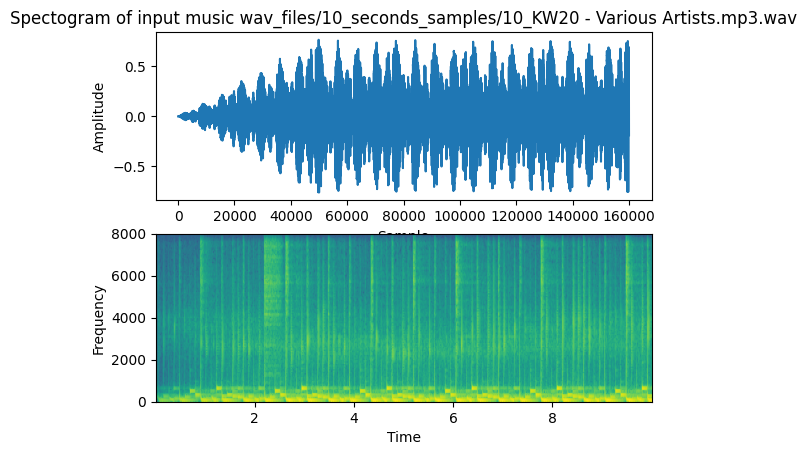

In [75]:
import matplotlib.pyplot as plot

 

# Plot the signal read from wav file

plot.subplot(211)

plot.title('Spectogram of input music {}'.format(inp_file))

 

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

 

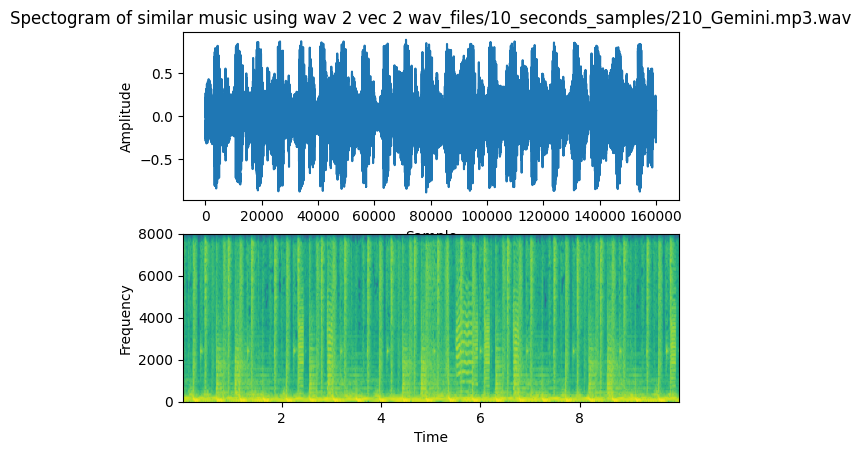

In [76]:
# Plot the signal read from wav file

plot.subplot(211)

plot.title('Spectogram of similar music using wav 2 vec 2 {}'.format(matched_file_wav))

waveform, sample_rate = torchaudio.load(matched_file_wav)
waveform = waveform.squeeze().numpy()

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

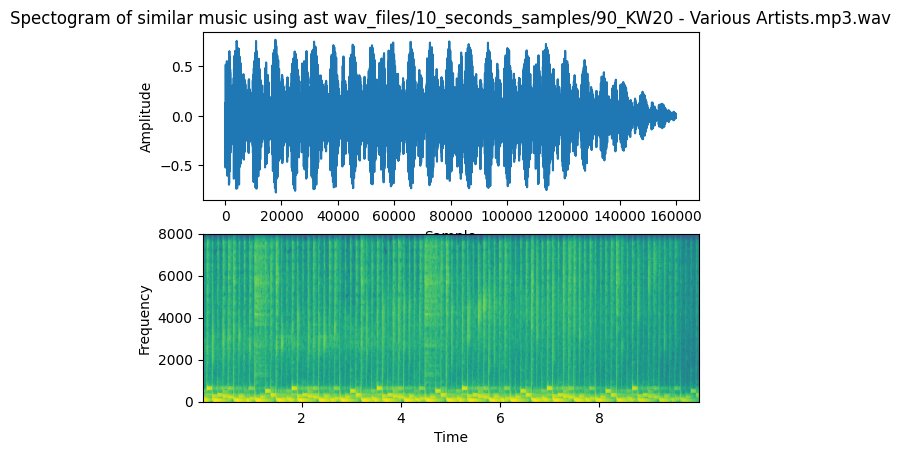

In [77]:
plot.subplot(211)

plot.title('Spectogram of similar music using ast {}'.format(matched_file_ast))

waveform, sample_rate = torchaudio.load(matched_file_ast)
waveform = waveform.squeeze().numpy()

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

In [59]:
import numpy as np
from docarray import DocumentArray
from docarray import base

docs = DocumentArray.empty(index_ast.ntotal)

In [ ]:
docs.embeddings

In [50]:
docs.embeddings = embeddings_ast

In [ ]:
docs.

In [58]:
docs.plot_embeddings(port=8892, host='0.0.0.0')

/home/ubuntu/audio_llm/venv/lib/python3.10/site-packages/docarray/array/mixins/plot.py:277: UserWarning: Showing iframe in cell, you may want to open http://0.0.0.0:8892/static/index.html?config=config.json in a new tab for better experience. Also, `localhost` may need to be changed to the IP address if your jupyter is running remotely. Click "stop" button in the toolbar to move to the next cell.
  warnings.warn(


KeyboardInterrupt: 